<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Laplacian-Scale-Space:" data-toc-modified-id="Laplacian-Scale-Space:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Laplacian Scale Space:</a></span><ul class="toc-item"><li><span><a href="#Step-1" data-toc-modified-id="Step-1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Step 1</a></span></li><li><span><a href="#Step-2" data-toc-modified-id="Step-2-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Step 2</a></span></li><li><span><a href="#Step-3" data-toc-modified-id="Step-3-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Step 3</a></span></li></ul></li><li><span><a href="#Maxima-Detection." data-toc-modified-id="Maxima-Detection.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Maxima Detection.</a></span></li><li><span><a href="#----Discarded----" data-toc-modified-id="----Discarded-----3"><span class="toc-item-num">3&nbsp;&nbsp;</span>--- Discarded ---</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/CE6003_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CE6003 Assignment 1. - Scale Invariant "blob" keypoint detector. 

In this assignment you will code a scale invariant keypoint detector that can detect circular or blob like regions in an image. The goal of the assignment is to build a detector so that the dark circular regions in the centres of the sunflowers at different scales in the image can be found & marked.

![](https://github.com/tonyscan6003/CE6003/blob/master/images/img_result.JPG?raw=true)

As we have seen in the notes there are several possible ways to buid such a keypoint detector. For this assignment you will construct a Laplacian (of gaussian) scale space for the test image, and then seach this scale space for maxima that correspond to blobs in the image at different scales.

We will firstly load the required python packages and import the test image of sunflowers and display it. 

In [1]:
import numpy as np
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import math
from scipy import signal
from tqdm import tqdm  

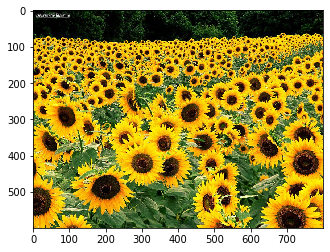

In [2]:
image_url_flowers = "https://t.wallpaperweb.org/wallpaper/nature/1600x1200/Field_of_Sunflowers_Kentucky.jpg"

# Function to read images from the Web.
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
    temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
    return temp_image

def read_image():
   # read Image 
    sf =2
    image = url_to_image(image_url_flowers)
    #Scale Image by sf = 2
    x,y,z = np.shape(image)
    image_scale = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    #Convert to Greyscale
    gray = cv2.cvtColor(image_scale, cv2.COLOR_BGR2GRAY)
    return image_scale,gray

image_scale,gray = read_image()
plt.imshow(image_scale)

# Laplacian Scale Space:

Our goal in this section is to generate a laplacian scale space for the test image. We will perform this in three steps.

> **Step 1**: We will code a function that can generate kernel functions i.e. the 2nd order paratial derivatives of the gaussian function  $$\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{x}^2},\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{y}^2}$$ 

> **Step 2**: We will code a function that convolves the image with gaussian derivative kernels to produce the Laplacian of Gaussians for any value of sigma.

> **Step 3**: We will use the convolution function we have just written in a for loop to create the scale space images and assign them to an array.

**Computation of kernels:**
As shown in the notes 1_4 (part B) (slide 4) the Laplacian scale space (for a given sigma) is formed from convolution of the partial derivatives of the gaussian kernel with the input image.
It is however computationally inefficient to convolve these large 2d kernels with the image. *Therefore the gaussian partial derivative kernels should be instead determined as seperable convoutions*. That is 2 sequential convolutions with 1d kernels. 

Useful Information:
> The gaussian 1d forms including the 1st and 2nd order derivatives can be found [here](http://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/04%20Gaussian%20derivatives.pdf)

> Seperable convolutions: Lecture 1_1 & [here](http://www.songho.ca/dsp/convolution/convolution2d_separable.html)

> [Scipy 2d Convolution command](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) (can be used with 1xn arrays as well as m x n):

> Numpy expand dims can be used to turn a list into an array

> Numpy transpose can be used to obtain transpose of an array



**Scale space range**: The code cell below defines a range of sigma values to generate your scale space over.

In [3]:
# Define Scale space
sigma_min = 1
sigma_max = 32
scale_fac = 1.05
# number of filters in scale space
num_scales = int((sigma_max-sigma_min)/scale_fac)
print("The number of scales is ",num_scales)
sigma_vals = np.linspace(sigma_min,sigma_max,num_scales) # Range of sigma values for scale space

The number of scales is  29


## Step 1

**Step 1:** In the code cell below you should complete the function that can output the 1d kernels that can be used to form the 2d Gaussians derivative kernels $$\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{x}^2},\frac{\partial^2{G(\mathbf{x},\sigma)}}{\partial{y}^2}$$ for a given sigma value. Hint: The same two 1d kernels are necessary to generate both 2D gaussian derivative kernels.

Note 
> When generating 1d gaussian kernels it is necessary to ensure there are enough samples in the window for the gaussian to decay to zero (see lecture 1_1). With larger sigma values bigger kernels are needed. The code snippet below gives the range of samples needed for generating gaussian kernels of different sizes.
```
    k_size = int(6*sigma+1)
    rng = (k_size-1)//2
    x = np.arange(-rng,rng+1)
```



**K1 = 1D Gaussian Distribution 0th-order**

$$
G(x,\sigma) = 
\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}$$


**K2 = 1D Gaussian Distribution Derivative 2nd-order**

$$
\frac{\partial^2}{\partial x^2}G(x,\sigma) =
\frac{1}{\sigma^5\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}(x^2-\sigma^2)
$$

In [4]:
# Determines kernels for partial derivatives 
def gauss_kernels(sigma):
    """
    sigma: Parameter controlling Gaussian blur
    K1: 1d kernel 1 x 2*rng+1 array 
    K2: 1d kernel 1 x 2*rng+1 array 
    """
    # Work out necessary kernel size and range to generate gaussian over.
    k_size = int(6*sigma+1)
    rng = (k_size-1)//2         # Floor Operator
    x = np.arange(-rng,rng+1)   # Array of ints from -rng to +rng

    # Define 1 dimensional gaussian kernels 

    #### Your Code Here ###
    #K1 : G(x,sigma) : 1D Gauss : Oth-Order
    K1 =  1/(sigma   *np.sqrt(2*np.pi)) * np.exp(-(x**2)/(2*sigma**2))
    #K2 : d^2/dx^2 G(x,sigma) : 1D Gauss : 2nd-order derivative
    K2 =  1/(sigma**5*np.sqrt(2*np.pi)) * np.exp(-(x**2)/(2*sigma**2))*(x**2-sigma**2)
    
    return K1,K2

Before moving to the next step, You can test if you can correctly generate the required 2D kernels from the 1D kernels by obtaining the outer product of the 1d kernels and plotting the result.

https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

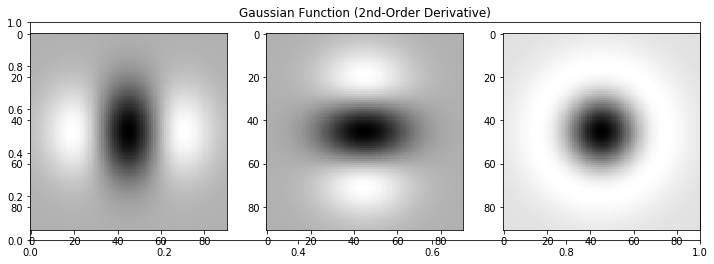

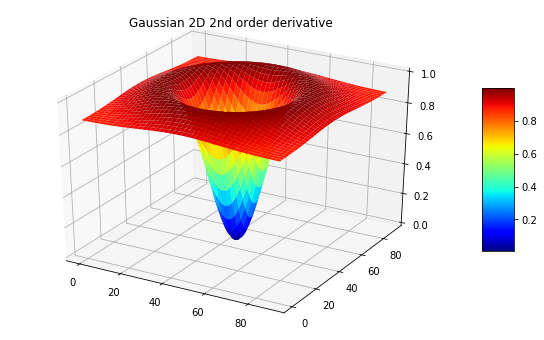

In [5]:
# Sigma
sigma=15
# Get 1D kernal and its 1st and Second derivative
K1,K2 = gauss_kernels(sigma)

# Plots
def plot_filter(A,i):
    ax = fig.add_subplot(num_filt,3, i)
    ax.imshow(A,'gray')

### Plot Setup
num_filt=1

### Gaussian Function 2nd-Derivative
K_2d_x = np.outer(K1,K2)
K_2d_y = K_2d_x.T
fig = plt.figure(figsize=(12,4))
plt.title("Gaussian Function (2nd-Order Derivative)")
plot_filter(K_2d_x, 1) 
plot_filter(K_2d_y, 2)
plot_filter(K_2d_x + K_2d_y, 3)
plt.show();

#3D
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')

combined = (K_2d_x + K_2d_y)
combined = (combined - np.min(combined)) / (np.max(combined) - np.min(combined))
x = np.arange(combined.shape[0])
y = np.arange(combined.shape[1])
X,Y = np.meshgrid(x,y)
Z = combined[X,Y]

mycmap = plt.get_cmap('jet')
ax1.set_title('Gaussian 2D 2nd order derivative')
derv_2D = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(derv_2D, ax=ax1, shrink=0.5, aspect=5)

plt.show()

## Step 2

**Step 2:** In the code cell below you should complete the function that can output the normalised lapacian of a greyscale image for a given sigma value. You can re-use the function to generate the 1d kernels and then convolve the input image using seperable convolution as mentioned above.

In [6]:
#### Your Code Here ### 
def laplacian(sigma,image):
    """
    sigma: Parameter controlling Gaussian blur
    image: input greyscale image n x m
    conv_laplacian: output image n x m to be returned, 
                    result of convolution of image with laplacian of Gaussian  
    """
    # 1 dimension gaussian kernels (Integration scale)
    '''
    K1 is the 1D Gaussian distribution Kernel
    K2 is the 1D Gaussian distribution 2nd Order Derivative Kernel
    '''
    K1,K2 = gauss_kernels(sigma)

    # Form Derivatives of Image with Gaussian
    # (with sequential 1d convolution.)

    #### Your Code Here ###
    
    # Add a simple expression to determine
    # the 2D 2nd order gaussian derivative
    # in the x direction and y direction
    gx = np.expand_dims(K1, axis=0)
    gy = gx.T
    gffx = np.expand_dims(K2, axis=0)
    gffy = gffx.T
    
    #First Smooth, then 2nd derv
    conv_y = signal.convolve2d(image, gx, boundary='fill', mode='same')
    img_y = signal.convolve2d(conv_y, gffy, boundary='fill', mode='same')
    
    #No Smoothing
    #img_y = signal.convolve2d(image, gffy, boundary='fill', mode='same')
    
    #First Smooth, then 2nd derv
    conv_x = signal.convolve2d(image, gy, boundary='fill', mode='same') #Initially gx
    img_x = signal.convolve2d(conv_x, gffx, boundary='fill', mode='same')
    
    #No Smoothing
    #img_x = signal.convolve2d(image, gffx, boundary='fill', mode='same')
    
    summed = sigma**2*(img_y + img_x)
    
    #normalised = (summed - np.min(summed)) / (np.max(summed) - np.min(summed))
    not_normalised = summed
    conv_laplacian = not_normalised
    
    return conv_laplacian

## Step 3

**Step 3:** Using the function that you have written, we will now iterate through the given sigma values and stack (using dstack) each scale space image to the array `laplace_scale_space`. This output array should be of dimension $n\times m \times k$ where $n$ and $m$ are the dimensions of the image and $k$ is the number of scales (`num_scales`).
We use greyscale image `gray` with your function along with each sigma value (not the original color image).

np.dstack: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html





In [7]:
# Initialise scale space as empty
laplace_scale_space = []
# Initialise pointer
ptr = 0

for k in tqdm(range(num_scales), position=0, leave=True): # For each sigma in scale space
   #Generate matrix components
   conv_laplacian = laplacian(sigma_vals[k],gray)
   # add to scale space
   laplace_scale_space = np.dstack((laplace_scale_space,conv_laplacian)) if ptr>0 else conv_laplacian
   #update pointer
   ptr += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:29<00:00,  1.02s/it]


**View Lapacian Scale Space** If you have correctly generated the lapacian scale space, you can use the function in the cell below to visualise the scale space. The function will plot the laplacian and the square of the laplacian. (Note that your laplacian scale space will contain both positive and negative values, but the plot function will automatically offset and scale the values for dispay)

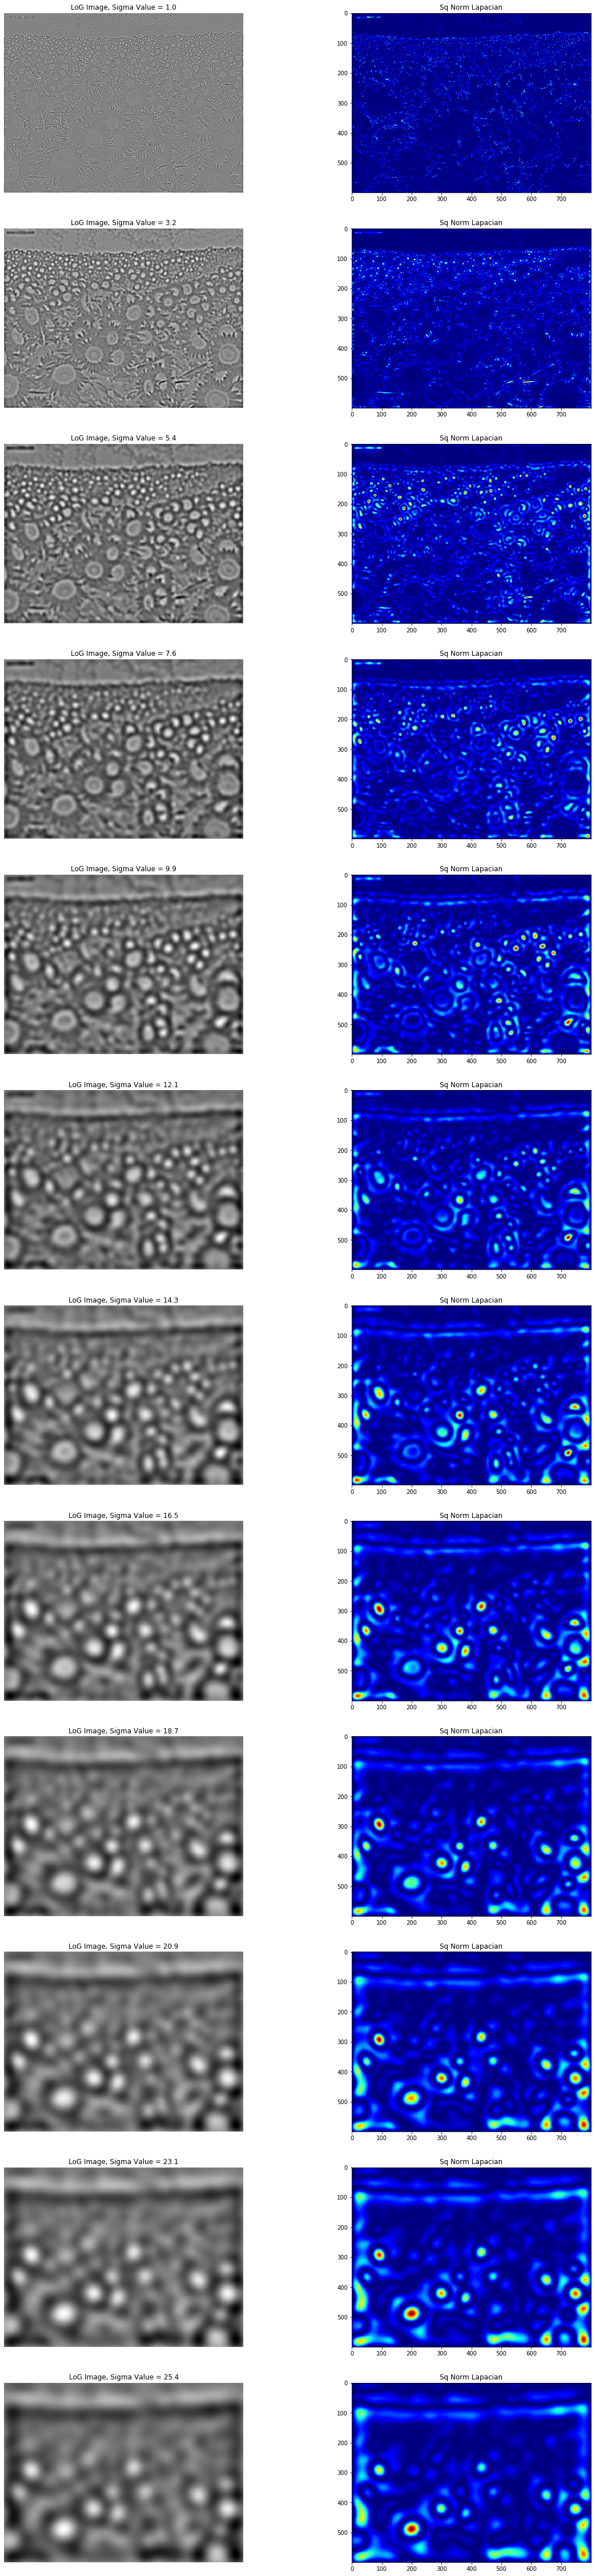

In [8]:
fig = plt.figure(figsize=(20,200))

def plot_filter(A,B,sigma,i):
    title_val = np.round(sigma,decimals=1)
    ax = fig.add_subplot(num_scales, 2, 2*(i+1)-1)
    ax.imshow(A,'gray')
    ax.title.set_text('LoG Image, Sigma Value = '+str(title_val))
    ax.axis('off')
    ax = fig.add_subplot(num_scales, 2, 2*(i+1))
    ax.imshow(B,'jet')
    ax.title.set_text('Sq Norm Lapacian')

ptr =0
# View Laplacian Scale space
for i in range(0,24,2):
    sigma = sigma_vals[i]
    laplace_conv = laplace_scale_space[:,:,i] 
    # Obtain square norm
    sq_norm = laplace_conv**2
    # Call plotting
    plot_filter(laplace_conv,sq_norm,sigma,ptr)
    ptr+=1



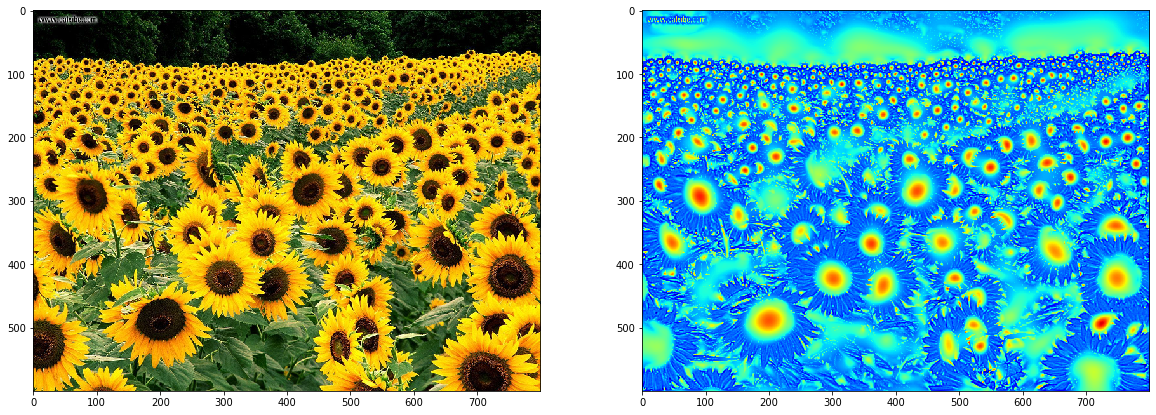

In [9]:
#Maximums across all scale spaces
maxMaglaplace_scale_space = laplace_scale_space.max(axis = 2)

# Show Original and Maxima Image
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_scale);
plt.subplot(122)
plt.imshow(maxMaglaplace_scale_space,'jet');

# Maxima Detection.
If you have completed the notebook successfuly to this point, you should be able to see the maxima in the Normalised Laplacian image that you generated correspond to the stuctures in the original image. It should be evident that the reponse is maximised at particular scales (sigma values) and at particular locations in the image. (Images should be similar to slide 3 of lecture 1_4 part B)

The next step is to find the exact location of the local maxima in x,y space and scale. This may be achieved by iterating though all of the scale space images and determining if each point in scale space is a local maximum by comparing it's magnitude with each of it's 26 nearest neighbours (as shown in slide 6 of the lecture slides 1_4 part B). You should be able to convince yourself with a simple 1d example that this algorithm can find local maxima over all scales and positions.

In the code cell below complete the function `lap_max_det` . This function sets the conditions for detection of a maxima.  A threshold value `thresh` should be included to ensure that we include the strong maxima and avoid too many detections. This function should return a list `max_det` when a maxima is detected (it returns an empty list otherwise). The magnitude of the detected maximum in Laplacian scale space, the x,y position and the scale sigma are stored in the list.  

The lap_max_det function is then used in the function `find_maxima` which contains a for loop (given) that iterates over all points in scale space and applies your condition to detect maxima.

Notes:

> The first and last images in the scale space are treated as auxillary images (i.e. These scale spaced are only used to assist in the determination of maxima of the 2nd and 2nd last layers.) 

> The numpy [ravel](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) command may be useful



 



In [14]:
ws = 3                       # Window size used for nearest neighbours 
max_coords = np.empty((1,4)) # Array to store detected coordinates (Initialised with Random Values)
eps = 1e-3                   # Small epsilon value
n_max = 0                    # Initialise variable counting no. maxima detected

# Comparision with Nearest Neighbours for maxima detection
def lap_max_det(x,y,k,thresh):
    sigma = sigma_vals[k]    # Associated sigma current scale
    """
      x,y,k: are current point coordinates in scale space.
      thresh: is a threshold to ignore values. 
      det_max: is a list containing, [mag, x, y, sigma ] 
                  mag: magnitude of maxium in scale space
                  x,y spatial coordinates
                  value of sigma for current scale
      laplace_scale_space: previously created array in notebook containing scale spaces 
    """
    # From Laplace Scale Space: Obtain magnitude of test point and 
    # nearest neighbours for comparison.

    #### Your Code Here ###  
    
    # Condition for max detection
    test_point = laplace_scale_space[x,y,k]
    x_lower = x - (ws//2)
    y_lower = y - (ws//2)
    k_lower = k - (ws//2)
    
    x_upper = x_lower + ws
    y_upper = y_lower + ws
    k_upper = k_lower + ws
    
    window = laplace_scale_space[x_lower:x_upper, y_lower:y_upper, k_lower:k_upper]
    
    #if (test_point == np.max(window)) and (test_point >= thresh):
    if (test_point == np.max(window)) and (test_point >= thresh):    
        det_max = [test_point,x,y,sigma]
    else:
        det_max =[]    # Output empty list if no max detected
    return det_max

In [11]:
thresh = 50                  # Choose Threshold value

x_max,y_max = np.shape(gray) # Maximum Rows and Columns of Image

def find_maxima(max_coords,n_max):
    """
    max_coords: is an array size n_max x 4 where n_max are the number of maxima found
    each row contains, [mag, x, y, sigma ] 
    mag: magnitude of detected maximum in scale space
    x,y spatial coordinates
    value of sigma for current scale.
    """
    # Iterate over scales
    for k in tqdm(range(1,num_scales-1), position=0, leave=True):
        # Iterate over spatial points
        for x in range(1,x_max-ws):
            for y in range(1,y_max-ws):
                det_max=lap_max_det(x,y,k,thresh)
                if det_max: # Add valid maxima to array (i.e. not an empty list)
                    max_coords = np.concatenate((max_coords,np.array([det_max]))) if n_max>0 else np.array([det_max])
                    n_max+=1 
    
    return max_coords,n_max

max_coords,n_max = find_maxima(max_coords,n_max)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:14<00:00,  2.77s/it]


**Display Maxima** The code below is provided to help you display you found keypoints over the original image. (some minor modification may be necessary depending on how you stored the keypoints from the last cell)

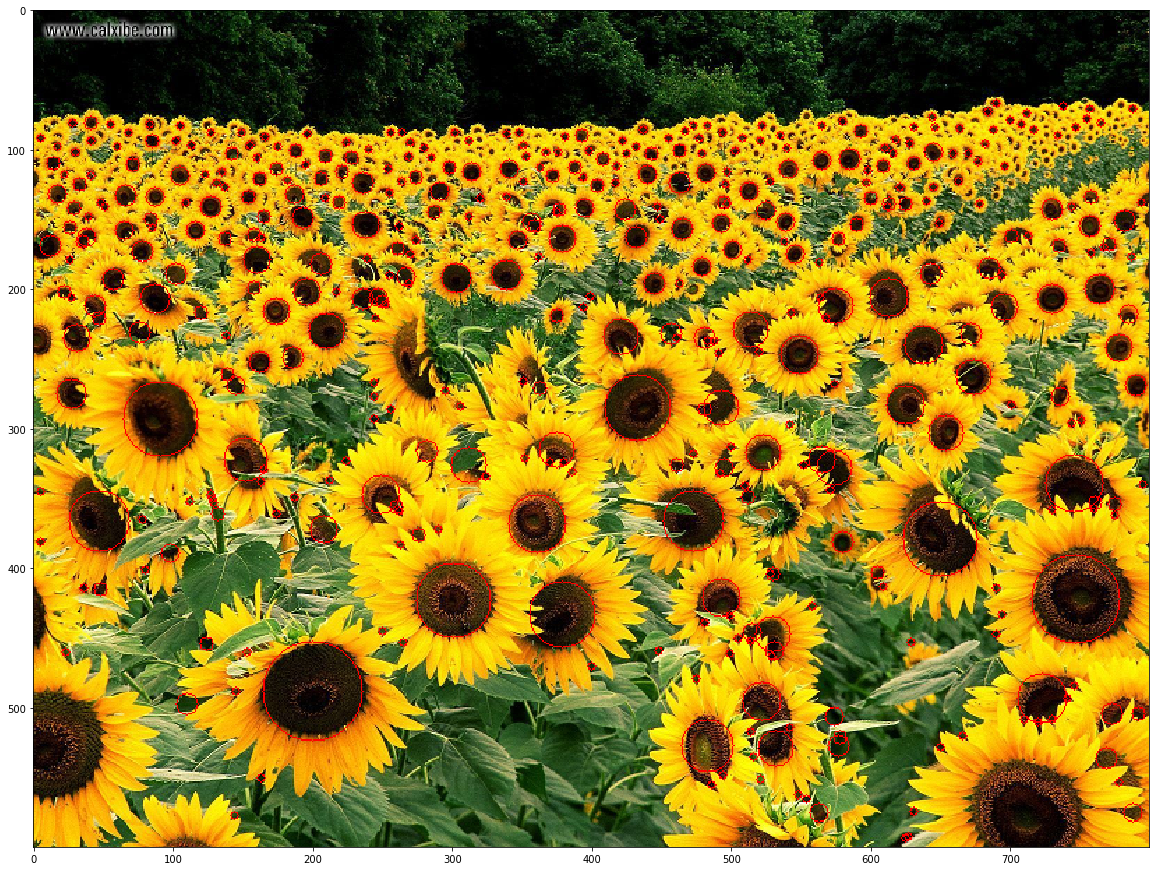

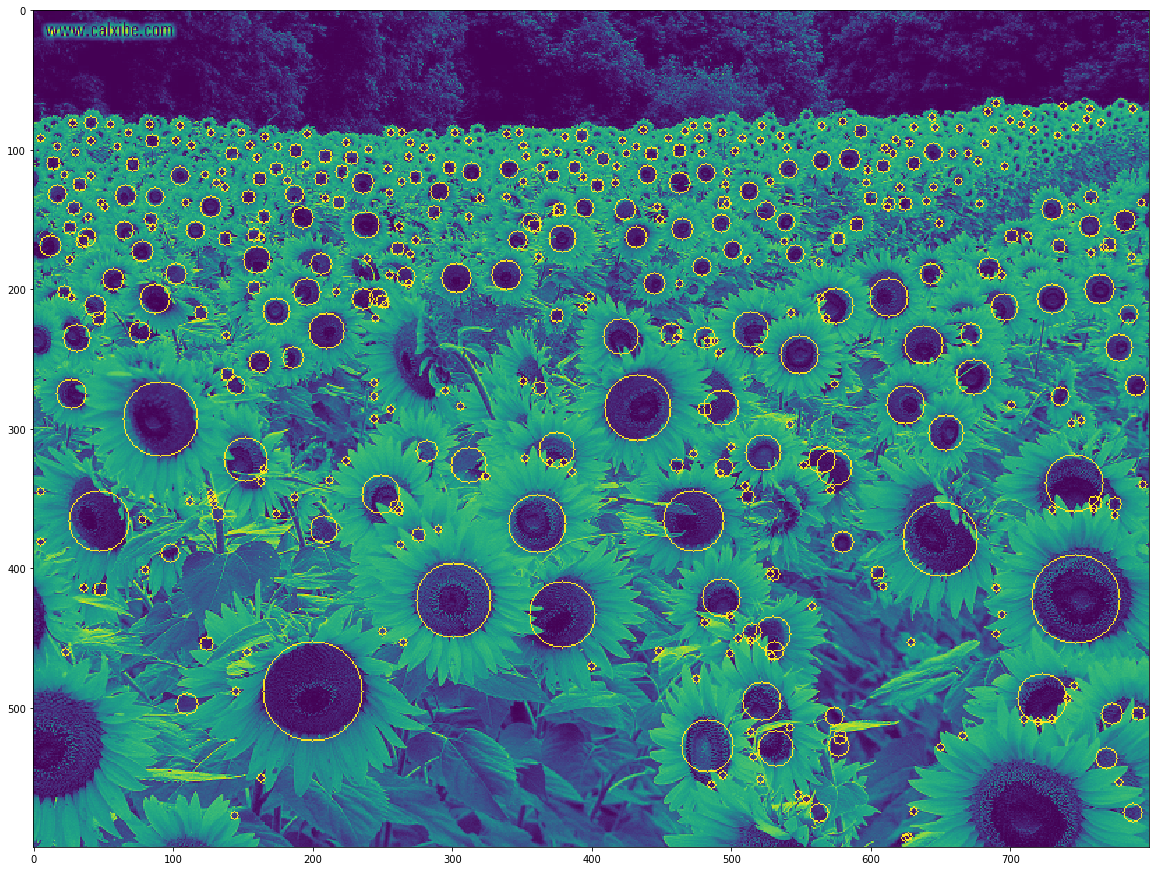

In [12]:
####Orig
# Sort the maxima and draw largest 250 on the image 
image,gray = read_image()

# sort in descending order (using magnitude)
index_coords=np.argsort(max_coords[:,0],axis=0)[::-1]

for i in index_coords[0:n_max]:
    [mag,x,y,sigma] = max_coords[i,:]
    br =int(math.ceil(1.414 * sigma))
    keypoints_img = cv2.circle(image, (int(y),int(x)), br, (255,0,0), 1)
    keypoints_gray = cv2.circle(gray, (int(y),int(x)), br, (255,0,0), 1)

# Plot keypoint image
plt.figure(figsize=(20,20))
plt.imshow(keypoints_img)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(keypoints_gray)
plt.show()

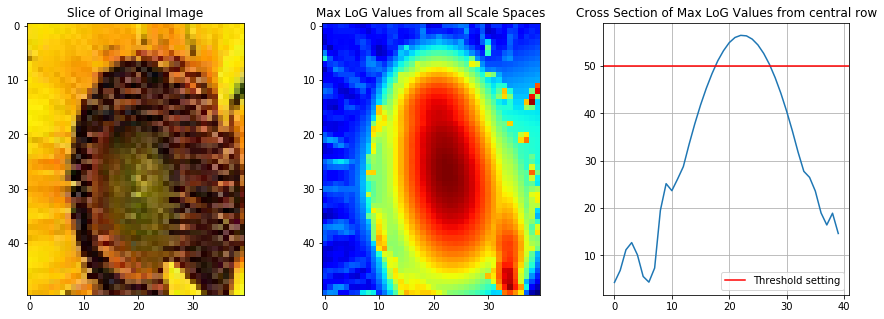

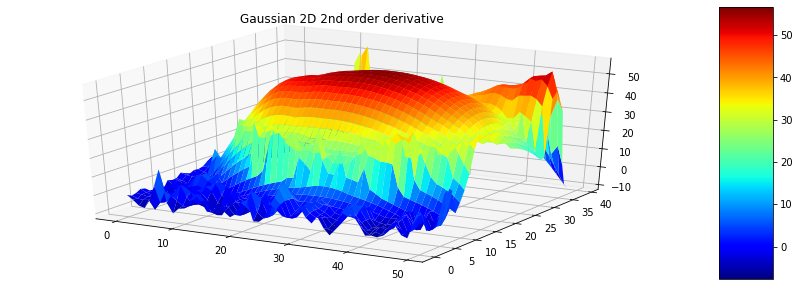

In [13]:
def sectionReview(laplace_scale_space, row_min, row_max, col_min, col_max):
    
    # Centre Row
    centre_row = int((row_min+row_max)/2)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("Slice of Original Image")
    plt.imshow(image_scale[row_min:row_max, col_min:col_max])

    plt.subplot(132)
    plt.title("Max LoG Values from all Scale Spaces")
    plt.imshow(laplace_scale_space.max(axis = 2)[row_min:row_max, col_min:col_max],'jet')
    #plt.colorbar()


    plt.subplot(133)
    plt.title("Cross Section of Max LoG Values from central row")
    plt.plot(laplace_scale_space.max(axis=2)[centre_row, col_min:col_max])
    plt.axhline(thresh, label="Threshold setting", c='r')
    #plt.colorbar()
    plt.grid()
    plt.legend()

    plt.show()
    
    #3D
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(111, projection='3d')

    combined = laplace_scale_space.max(axis = 2)[row_min:row_max, col_min:col_max]
    x = np.arange(combined.shape[0])
    y = np.arange(combined.shape[1])
    X,Y = np.meshgrid(x,y)
    Z = combined[X,Y]

    mycmap = plt.get_cmap('jet')
    ax1.set_title('Gaussian 2D 2nd order derivative')
    derv_2D = ax1.plot_surface(X, Y, Z, cmap=mycmap)
    fig.colorbar(derv_2D, ax=ax1, shrink=1, aspect=5)

    plt.show()

row_min, row_max, col_min, col_max = 500,550,460,500
sectionReview(laplace_scale_space, row_min, row_max, col_min, col_max)

**Comments:** Please leave any comments in this text box that you have on your results or approach for your moderator.

# --- Discarded ---

**1D Gaussian Distribution 0th-order**

$$
G(x,\sigma) = 
\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}$$

**1D Gaussian Distribution Derivative 1st-order**

$$
\frac{\partial}{\partial x}G(x,\sigma) = 
-\frac{1}{\sigma^3\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}x
$$

**1D Gaussian Distribution Derivative 2nd-order**

$$
\frac{\partial^2}{\partial x^2}G(x,\sigma) =
\frac{1}{\sigma^5\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}(x^2-\sigma^2)
$$